In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import gzip
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
# Load the dataset
file_path = '/content/drive/MyDrive/hotel_rec/hotelrec_superclean.csv.gz'

with gzip.open(file_path, 'rt') as f:
    df = pd.read_csv(f)

## Data cleaning

In [ ]:
print(df.isnull().sum())

hotel_id              0
hotel_name            0
hotel_location        0
author                0
date                  0
rating                0
sentiment_score       0
service               0
year                  0
new_hotel_id          0
author_id             0
hotel_id_enc          0
author_enc            0
hotel_location_enc    0
year_scaled           0
dtype: int64


In [ ]:
# Drop rows with missing 'author'
df.dropna(subset=['author'], inplace=True)

In [ ]:
# Drop rows with missing 'hotel_location'
df.dropna(subset=['hotel_location'], inplace=True)

In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.year

In [ ]:
# Step 1: Create a new hotel_id based on hotel_name and hotel_location
df['new_hotel_id'] = df.groupby(['hotel_name', 'hotel_location']).ngroup()

# Verify the results
print(df[['hotel_name', 'hotel_location', 'new_hotel_id']].drop_duplicates().head())


                            hotel_name  \
0                         Hotel Baltic   
6              Pousada Rumo dos Ventos   
20  Agriturismi Il Castello La Grancia   
45                  El Mosaico del Sol   
57         Villa Huinid Hotel Pioneros   

                                       hotel_location  new_hotel_id  
0               Giulianova Province of Teramo Abruzzo        143129  
6                      Paraty State of Rio de Janeiro        267465  
20                                     Pienza Tuscany          6001  
45                 Lampedusa Islands of Sicily Sicily         94376  
57  San Carlos de Bariloche Province of Rio Negro ...        350882  


In [ ]:
# prompt: drop cols sleep quality, rooms, cleanliness, location

df = df.drop(columns=['sleep quality', 'rooms', 'cleanliness', 'location', 'value'])


In [ ]:
df.head()

,hotel_id,hotel_name,hotel_location,author,date,rating,sentiment_score,service,year,new_hotel_id,author_id
0,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,violettaf340,2019-01,5.0,0.341327,5.0,2019,143129,0
1,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,Lagaiuzza,2016-01,5.0,0.272183,5.0,2016,143129,1
2,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,ashleyn763,2014-10,5.0,0.475000,5.0,2014,143129,2
3,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,DavideMauro,2014-08,5.0,0.623636,5.0,2014,143129,3
4,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,Alemma11,2013-08,4.0,0.218607,5.0,2013,143129,4


In [ ]:
# Step 1: Calculate global median for service
global_median_service = df['service'].median()

# Step 2: Calculate the median service per new_hotel_id and hotel_location
median_service_by_hotel_id = df.groupby('new_hotel_id')['service'].median()
median_service_by_location = df.groupby('hotel_location')['service'].median()

# Step 3: Merge the median values into the dataframe
df = df.merge(median_service_by_hotel_id, on='new_hotel_id', how='left', suffixes=('', '_hotel'))
df = df.merge(median_service_by_location, on='hotel_location', how='left', suffixes=('', '_location'))

# Step 4: Impute missing service values
df['service'] = df['service'].fillna(df['service_hotel'])  # First try hotel-level median
df['service'] = df['service'].fillna(df['service_location'])  # If still missing, try location-level median
df['service'] = df['service'].fillna(global_median_service)  # If still missing, use global median

# Drop the temporary median columns
df.drop(columns=['service_hotel', 'service_location'], inplace=True)

# Verify the result
print(df[['new_hotel_id', 'hotel_location', 'service']].isna().sum())  # Check if any NaN left


new_hotel_id      0
hotel_location    0
service           0
dtype: int64


In [ ]:
# Create a unique author_id for each unique author
df['author_id'] = pd.factorize(df['author'])[0]

# Check the result to verify
print(df[['author', 'author_id']].drop_duplicates().head())

         author  author_id
0  violettaf340          0
1     Lagaiuzza          1
2    ashleyn763          2
3   DavideMauro          3
4      Alemma11          4


In [ ]:
df.to_csv('/content/drive/MyDrive/hotel_rec/hotelrec_superclean.csv.gz', index=False, compression='gzip')

## NeuMF

In [4]:

df['hotel_id_enc'] = df['new_hotel_id']
df['author_enc'] = df['author_id']

In [5]:
# Step 1: Define ID mappings (reserve index 0 for unknowns)
def build_id_map(series):
    unique = sorted(series.unique())
    return {v: i + 1 for i, v in enumerate(unique)}  # 0 reserved for unknown

def map_ids(series, id_map):
    return series.map(id_map).fillna(0).astype(int)

# Step 2: Build mappings for hotel and author
hotel_id_map = build_id_map(df['hotel_id_enc'])
author_id_map = build_id_map(df['author_enc'])

# Step 3: Apply mappings with fallback to 0 for unknowns
df['hotel_id_enc'] = map_ids(df['hotel_id_enc'], hotel_id_map)
df['author_enc'] = map_ids(df['author_enc'], author_id_map)

In [6]:
scaler = StandardScaler()
df[['service', 'sentiment_score', 'year_scaled']] = scaler.fit_transform(df[['service', 'sentiment_score', 'year']])


In [7]:
# Define inputs and target
X_cat = df[['hotel_id_enc', 'author_enc']]
X_num = df[['service', 'sentiment_score']]
y = df['rating']

In [8]:
# Train-validation split
X_cat_train, X_cat_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_cat, X_num, y, test_size=0.3, random_state=42)

In [9]:
# Custom Dataset
class HotelDataset(Dataset):
    def __init__(self, X_cat, X_num, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_num = torch.tensor(X_num.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

In [14]:

# DataLoaders
train_ds = HotelDataset(X_cat_train, X_num_train, y_train)
val_ds = HotelDataset(X_cat_val, X_num_val, y_val)

train_dl = DataLoader(train_ds, batch_size=4000, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4000)

In [11]:
# Update input dimensions for model init
n_hotels = len(hotel_id_map) + 1
n_authors = len(author_id_map) + 1

In [12]:
class HotelNeuMF(nn.Module):
    def __init__(self, n_hotels, n_authors, embed_size=32):
        super().__init__()

        # Embedding layers
        self.hotel_emb = nn.Embedding(n_hotels, embed_size)
        self.author_emb = nn.Embedding(n_authors, embed_size)

        # GMF block
        self.gmf = nn.Sequential(
            nn.Linear(embed_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(embed_size * 2 + 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Final fusion layer
        self.final = nn.Sequential(
            nn.Linear(2, 1)
        )

    def forward(self, hotel_ids, author_ids, service, sentiment_score):
        hotel_emb = self.hotel_emb(hotel_ids)
        author_emb = self.author_emb(author_ids)

        emb_cat = torch.cat([hotel_emb, author_emb], dim=1)

        gmf_out = self.gmf(emb_cat)

        mlp_input = torch.cat([
            emb_cat,
            service.unsqueeze(1),
            sentiment_score.unsqueeze(1)
        ], dim=1)

        mlp_out = self.mlp(mlp_input)

        combined = torch.cat([gmf_out, mlp_out], dim=1)
        rating = self.final(combined)

        return rating.squeeze()


In [16]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HotelNeuMF(
    n_hotels=n_hotels,
    n_authors=n_authors,
).to(device)

In [17]:
from torch.optim.lr_scheduler import OneCycleLR

loss_fn = nn.MSELoss()
# Optimizer (start with a lower base LR)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler with warmup + decay
scheduler = OneCycleLR(optimizer,
                       max_lr=1e-2,             # peak LR
                       steps_per_epoch=len(train_dl),
                       epochs=15,
                       pct_start=0.3,           # warmup for 30% of total steps
                       anneal_strategy='cos',   # cosine annealing
                       div_factor=8.0,          # start LR = max_lr / div_factor
                       final_div_factor=1e4)    # how small the final LR should be

In [18]:
# prompt: add progress bar and estimate traing time

from tqdm import tqdm

# Training Loop
train_losses = []
val_losses = []
epochs = 3
best_val_loss = float('inf')  # Start with the worst possible loss

import time

start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()  # Time at the beginning of the epoch
    model.train()
    train_loss = 0.0
    train_loop = tqdm(train_dl, leave=False) # wrap train_dl with tqdm
    for x_cat, x_num, y in train_loop:
        optimizer.zero_grad()
        preds = model(x_cat[:, 0].to(device), x_cat[:, 1].to(device),
                        x_num[:, 0].to(device), x_num[:, 1].to(device))
        loss = loss_fn(preds.squeeze(), y.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        train_loop.set_postfix(loss=loss.item()) # add loss to progress bar

    avg_train_loss = train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_cat, x_num, y in val_dl:
            preds = model(x_cat[:, 0].to(device), x_cat[:, 1].to(device),
                            x_num[:, 0].to(device), x_num[:, 1].to(device))
            loss = loss_fn(preds.squeeze(), y.to(device))
            val_loss += loss.item()

    scheduler.step()

    avg_val_loss = val_loss / len(val_dl)
    val_losses.append(avg_val_loss)

    epoch_end_time = time.time() # Time at the end of the epoch
    epoch_time = epoch_end_time - epoch_start_time
    remaining_time = (epochs - (epoch+1)) * epoch_time  # Estimated remaining time

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Epoch Time: {epoch_time:.2f}s, Est. Remaining Time: {remaining_time:.2f}s")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/hotel_rec/train1/best_hotel_model.pt')
        print(f"✅ Model saved at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/3, Train Loss: 0.5467, Val Loss: 0.4263, Epoch Time: 3140.86s, Est. Remaining Time: 6281.72s
✅ Model saved at epoch 1 with Val Loss: 0.4263


Epoch 2/3, Train Loss: 0.4104, Val Loss: 0.4263, Epoch Time: 3194.13s, Est. Remaining Time: 3194.13s
✅ Model saved at epoch 2 with Val Loss: 0.4263


Epoch 3/3, Train Loss: 0.3996, Val Loss: 0.4165, Epoch Time: 3204.80s, Est. Remaining Time: 0.00s
✅ Model saved at epoch 3 with Val Loss: 0.4165
Total training time: 9575.49 seconds


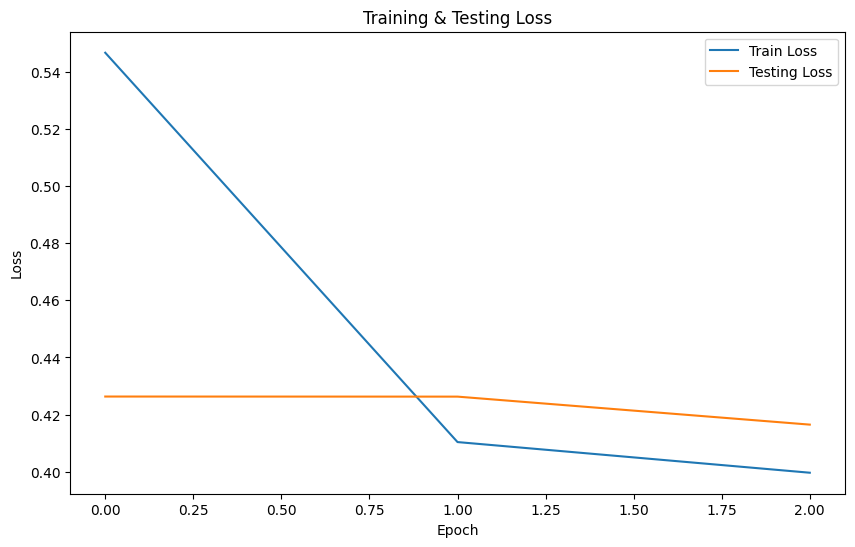

In [22]:
# Plotting Losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Testing Loss')
plt.legend()
plt.show()

In [23]:
# Load the best model (if you saved it)
model.load_state_dict(torch.load('/content/drive/MyDrive/hotel_rec/train1/best_hotel_model.pt'))
model.to(device)

# Switch to evaluation mode
model.eval()

# Initialize variables to track loss and accuracy
test_loss = 0.0
predictions = []
true_values = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for X_cat, X_num, y in val_dl:  # Or use `test_dl` if testing set
        X_cat, X_num, y = X_cat.to(device), X_num.to(device), y.to(device)

        # Unpack categorical and numerical features
        hotel_ids, author_ids = X_cat[:, 0], X_cat[:, 1]
        service, sentiment_score = X_num[:, 0], X_num[:, 1]

        # Get predictions from the model
        preds = model(hotel_ids, author_ids, service, sentiment_score).squeeze()

        # Calculate loss
        loss = loss_fn(preds, y)
        test_loss += loss.item()

        # Collect predictions and true values for evaluation
        predictions.extend(preds.cpu().numpy())  # Move to CPU for storage
        true_values.extend(y.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(val_dl)
print(f"Test Loss: {avg_test_loss:.4f}")

# Optionally, calculate RMSE or other metrics
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(true_values, predictions))
print(f"RMSE: {rmse:.4f}")


Test Loss: 0.4165
RMSE: 0.6454
